#### Копируем репозиторий и устанавливаем зависимости

In [27]:
ls lr_hse/01-toxic-review-classification/

README.md             requirements.txt      toxic_clf/
main.py               requirements_dev.txt


In [15]:
!git clone https://github.com/ai4se-course/ai4se-hse-course-24-25.git lr_hse

Cloning into 'lr_hse'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 5 (from 1)
Receiving objects: 100% (12/12), 4.42 KiB | 2.21 MiB/s, done.


In [ ]:
!pip3 install -r ./lr_hse/01-toxic-review-classification/requirements.txt \
              -r ./lr_hse/01-toxic-review-classification/requirements_dev.txt

#### Импортируем необходимые библиотеки

In [118]:
# EDA
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import re

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# Metrics
from sklearn.metrics import accuracy_score, \
                            confusion_matrix, \
                            precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

In [120]:
nltk.download('stopwords') # stop words
nltk.download('punkt') # tokenization

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rostislavvasin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rostislavvasin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [122]:
def prfs(y_true, preds) -> str:
    """ Вычисляет Precision, Recall, F-score

    Args:
        y_true (numpy.ndarray): Истинные значения
        preds (numpy.ndarray): Предсказанные значения

    Returns:
        str: Precision, Recall, F-score   
    """
    
    precicion, recall, f_score, sup = precision_recall_fscore_support(y_true, preds)
    return f'Precision – {precicion[1]}\nRecall – {recall[1]}\nF-score – {f_score[1]}'

#### Preprocess

In [125]:
path = './code-review-dataset-full.xlsx' # файл скачал на ноут, и закинул в колаб
df = pd.read_excel(path)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19651 entries, 0 to 19650
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   message   19647 non-null  object
 1   is_toxic  19651 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 307.2+ KB


In [129]:
# Посмотрим на количество пустых строк
df.isna().sum()

message     4
is_toxic    0
dtype: int64

In [131]:
# Удалим пустые сообщения
df = df.dropna().reset_index()

Сделаем небольшой препроцессинг:
1. оставляем буквы
2. lowercase
3. токенизируем
4. удаляем стоп-слова
5. для каждого слова найдём стемму


In [134]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [136]:
%%time
df['featues'] = df['message'].apply(lambda sent: re.sub('[^a-zA-Z]', ' ', sent)) \
                             .apply(lambda sent: sent.lower().strip()) \
                             .apply(lambda sent: word_tokenize(sent)) \
                             .apply(lambda sent: [stemmer.stem(word) for word in sent if word not in stop_words])

CPU times: user 2.31 s, sys: 25.7 ms, total: 2.34 s
Wall time: 2.35 s


In [137]:
df.featues = df.featues.apply(lambda sent: ' '.join(sent))

#### Поссотрим на баланс классов

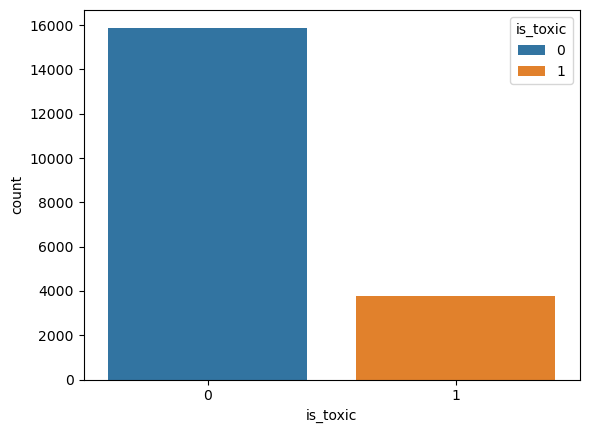

In [141]:
sns.countplot(data=df, x='is_toxic', hue='is_toxic');

Видим явный дисбаланс классов. Пока ничего не делаем. Сначала посмотрим на метрики

In [144]:
df.featues.drop_duplicates(inplace=True)

Удалили дубликаты, делаем TF-IDF

In [147]:
tf_idf = TfidfVectorizer()
features = tf_idf.fit_transform(df.message.values)

In [149]:
features = features.toarray()

In [151]:
labels = df.is_toxic.to_list()

#### Обучение
Разобьем выборки на тренировочную и тестовую в соотношении 80:20. На 80% проведем обучение моделей, применив кросс-валидацию на 10 фолдах. После проверим качество модели на тестовых данных, используя Confusion Matrix

In [154]:
X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                                    train_size=.8,
                                                    random_state=42)

Обучим __логистическую регрессию__ с настройками по умолчанию

In [175]:
lr = LogisticRegression(random_state=42, n_jobs=-1)
params = {
    'C':[1]
}
model_lr = GridSearchCV(lr, 
                        param_grid=params,
                        cv=10, 
                        n_jobs=-1,
                        return_train_score=True)

In [179]:
%%time
model_lr.fit(X_train, y_train)

CPU times: user 792 ms, sys: 2.16 s, total: 2.95 s
Wall time: 6min 12s


GridSearchCV(cv=10, estimator=LogisticRegression(n_jobs=-1, random_state=42),
             n_jobs=-1, param_grid={'C': [1]}, return_train_score=True)

Посмотрим на результаты

In [235]:
preds = model_lr.predict(X_test)
print(prfs(y_test, preds))

Precision – 0.928416485900217
Recall – 0.5721925133689839
F-score – 0.7080231596360629


Заметим, что модель хорошо определяет 0 класс, но часто ошибается в 1. Об этом говорит низкий рекол (__≈0.57__)

Построим матрицу несоответствий 

In [184]:
conf_matrix = confusion_matrix(y_test, logits)
tn, fp, fn, tp = conf_matrix.ravel()

In [185]:
conf_matrix

array([[3149,   33],
       [ 320,  428]])

Проведём оценку модели на 10 фолдовой кросс-валидации

#### Балансировка классов методом взвешивания
Воспользуемся _методом взвешивания классов_ для улучшения качества на несбалансированных данных и снова обучим модель

In [188]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [189]:
lr_weighted = LogisticRegression(class_weight=dict(enumerate(class_weights)))

params = {
    'C':[1]
}

model_lr_weighted = GridSearchCV(lr_weighted, 
                        param_grid=params,
                        cv=10, 
                        n_jobs=-1,
                        return_train_score=True)

In [190]:
model_lr_weighted.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight={0: 0.6183899905571294,
                                                        1: 2.6116650049850447}),
             n_jobs=-1, param_grid={'C': [1]}, return_train_score=True)

In [239]:
logits = model_lr_weighted.predict(X_test)
print(prfs(y_test, logits))

Precision – 0.7502837684449489
Recall – 0.8836898395721925
F-score – 0.8115408225905464


После балансировки классов __recall__ вырос от базовой модели, но точность упала

#### SMOTE
Попробуем применить к данным SMOTE

In [192]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [226]:
lr_smote = LogisticRegression(random_state=42, n_jobs=-1)

params = {
    'C':[1]
}

model_lr_smote = GridSearchCV(lr_smote, 
                        param_grid=params,
                        cv=10, 
                        n_jobs=-1,
                        return_train_score=True)

model_lr_smote.fit(X_resampled, y_resampled)

GridSearchCV(cv=10, estimator=LogisticRegression(n_jobs=-1, random_state=42),
             n_jobs=-1, param_grid={'C': [1]}, return_train_score=True)

In [241]:
logits = model_lr_smote.predict(X_test)
print(prfs(y_test, logits))

Precision – 0.8101910828025478
Recall – 0.8502673796791443
F-score – 0.8297455968688845


Модель со SMOTE бьёт начальную, но хуже метода взвешивания

#### Взвешивание + SMOTE
Теперь обучим модель, используя __оба__ подхода

In [202]:
max_model = LogisticRegression(class_weight=dict(enumerate(class_weights)))

model_lr_max = GridSearchCV(lr_smote, 
                        param_grid=params,
                        cv=10, 
                        n_jobs=-1,
                        return_train_score=True)

In [203]:
model_lr_max.fit(X_resampled, y_resampled)  

GridSearchCV(cv=10, estimator=LogisticRegression(n_jobs=-1, random_state=42),
             n_jobs=-1, param_grid={'C': [1]}, return_train_score=True)

In [204]:
logits = model_lr_max.predict(X_test)

In [243]:
print(prfs(y_test, logits))

Precision – 0.8101910828025478
Recall – 0.8502673796791443
F-score – 0.8297455968688845


In [206]:
confusion_matrix(y_test, logits)

array([[3033,  149],
       [ 112,  636]])

Модель научилась хорошо определять токсичные коментарии (recall ≈ 0.85), но при этом начала делать больше ошибок с нетоксичными

#### Тюнинг взвешивания 
Попробуем потюнить модель, обученную через метод взвешивания классов, так как она показала наиболее сбалансированный результат (смотрим на f-score)

In [207]:
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

lr_fine_tuned = GridSearchCV(lr_weighted, 
                        param_grid=params,
                        cv=10, 
                        n_jobs=-1,
                        return_train_score=True)

In [208]:
%%time
lr_fine_tuned.fit(X_train, y_train)

CPU times: user 24.9 s, sys: 4.67 s, total: 29.5 s
Wall time: 27min 20s


GridSearchCV(cv=10,
             estimator=LogisticRegression(class_weight={0: 0.6183899905571294,
                                                        1: 2.6116650049850447}),
             n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True)

In [245]:
logits = lr_fine_tuned.predict(X_test)
print(prfs(y_test, logits))

Precision – 0.8910344827586207
Recall – 0.8636363636363636
F-score – 0.8771215207060421


После тюнинга параматров удалось получить самую качественную модель. Её и оставляем